# Locality-Sensitive Hashing for Scalable Similarity Search

## Introduction to LSH and Similarity Search

### Seting up Environment

In [ ]:
# Install Required Packages
!pip install pyspark==3.5.0 -q
!pip install sentence-transformers -q
!pip install numpy pandas -q

# Install Java
# !apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Set Java Environment Variable
import os
import sys

# os.environ["JAVA_HOME"] = r"C:\Program Files\Java\jdk-17" Uncomment for windows

print("All packages installed successfully!")

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable



[notice] A new release of pip is available: 24.0 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


All packages installed successfully!



[notice] A new release of pip is available: 24.0 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col,
    udf,
    explode,
    array,
    lit,
    collect_list,
    size,
    lower,
    regexp_replace,
    split,
    monotonically_increasing_id,
    struct,
    when,
    coalesce,
    broadcast,
)
from pyspark.sql.types import (
    ArrayType,
    StringType,
    IntegerType,
    FloatType,
    StructType,
    StructField,
    DoubleType,
)
from pyspark.ml.feature import (
    HashingTF,
    CountVectorizer,
    MinHashLSH,
    Tokenizer,
    StopWordsRemover,
    NGram,
)
from pyspark.ml.linalg import Vectors, SparseVector, VectorUDT
from pyspark.ml import Pipeline

import numpy as np
import hashlib
from typing import List, Set, Tuple

# Create SparkSession for LSH operations
spark = (
    SparkSession.builder.appName("SSC454-LocalitySensitiveHashing")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.shuffle.partitions", "8")
    .config("spark.ui.port", "4050")
    .getOrCreate()
)

sc = spark.sparkContext

print(f"Spark version: {spark.version}")
print(f"Application name: {spark.sparkContext.appName}")
print("\nSpark Session ready for LSH operations!")

Spark version: 3.5.0
Application name: SSC454-LocalitySensitiveHashing

Spark Session ready for LSH operations!


### Sample Dataset

In [10]:
# Sample document data
documents = [
    (
        0,
        "Machine learning is a subset of artificial intelligence that enables systems to learn from data.",
    ),
    (
        1,
        "Artificial intelligence and machine learning allow computers to learn from data automatically.",
    ),
    (
        2,
        "Deep learning is a type of machine learning using neural networks with many layers.",
    ),
    (3, "The weather today is sunny with a high of 25 degrees celsius."),
    (
        4,
        "Today's weather forecast shows sunny skies and temperatures around 25 degrees.",
    ),
    (5, "Natural language processing helps computers understand human language."),
    (6, "NLP enables machines to process and understand natural human language."),
    (
        7,
        "Python is a popular programming language for data science and machine learning.",
    ),
    (
        8,
        "Data science often uses Python programming for machine learning applications.",
    ),
    (9, "The cat sat on the mat and watched the birds outside the window."),
    (10, "A small cat was sitting on a mat, watching birds through the window."),
    (11, "Apache Spark provides distributed computing for big data processing."),
    (
        12,
        "Big data processing is made efficient through distributed computing with Spark.",
    ),
    (
        13,
        "Locality sensitive hashing enables fast approximate nearest neighbor search.",
    ),
    (
        14,
        "LSH provides fast approximate nearest neighbor queries using hashing techniques.",
    ),
    (15, "The restaurant serves delicious Italian pasta and fresh salads daily."),
]

df_docs = spark.createDataFrame(documents, ["id", "text"])

print("Sample Document Corpus:")
df_docs.show(truncate=60)

Sample Document Corpus:
+---+------------------------------------------------------------+
| id|                                                        text|
+---+------------------------------------------------------------+
|  0|Machine learning is a subset of artificial intelligence t...|
|  1|Artificial intelligence and machine learning allow comput...|
|  2|Deep learning is a type of machine learning using neural ...|
|  3|The weather today is sunny with a high of 25 degrees cels...|
|  4|Today's weather forecast shows sunny skies and temperatur...|
|  5|Natural language processing helps computers understand hu...|
|  6|NLP enables machines to process and understand natural hu...|
|  7|Python is a popular programming language for data science...|
|  8|Data science often uses Python programming for machine le...|
|  9|The cat sat on the mat and watched the birds outside the ...|
| 10|A small cat was sitting on a mat, watching birds through ...|
| 11|Apache Spark provides distributed

## Document Shingling

### Character Shingles

In [11]:
def get_char_shingles(text: str, k: int = 5) -> List[str]:
    """Generate character k-shingles from text."""
    # Normalize text: lowercase, remove extra whitespace
    text = " ".join(text.lower().split())

    # Generate shingles
    shingles = [text[i : i + k] for i in range(len(text) - k + 1)]
    return shingles


# Example
sample_text = "Hello World"
char_shingles = get_char_shingles(sample_text, k=5)
print(f"Text: '{sample_text}'")
print(f"5-character shingles: {char_shingles}")
print(f"Number of shingles: {len(char_shingles)}")
print(f"Unique shingles: {len(set(char_shingles))}")

Text: 'Hello World'
5-character shingles: ['hello', 'ello ', 'llo w', 'lo wo', 'o wor', ' worl', 'world']
Number of shingles: 7
Unique shingles: 7


### Word Shingles (N-Grams)

In [12]:
def get_word_shingles(text: str, n: int = 3) -> List[str]:
    """Generate word n-gram shingles from text."""
    # Normalize and tokenize
    words = text.lower().split()
    # Generate n-grams
    shingles = [" ".join(words[i : i + n]) for i in range(len(words) - n + 1)]
    return shingles


# Example
sample_text = "Machine learning is a subset of artificial intelligence"
word_shingles = get_word_shingles(sample_text, n=3)
print(f"Text: '{sample_text}'")
print(f"\n3-word shingles:")
for i, shingle in enumerate(word_shingles):
    print(f"  {i + 1}. '{shingle}'")

Text: 'Machine learning is a subset of artificial intelligence'

3-word shingles:
  1. 'machine learning is'
  2. 'learning is a'
  3. 'is a subset'
  4. 'a subset of'
  5. 'subset of artificial'
  6. 'of artificial intelligence'


### Implementing Shingling in Spark

In [13]:
# Method 1: Using Spark's NGram transformer
def create_shingle_pipeline(n_values=[2, 3, 4]):
    """Create a pipeline for generating word n-grams of multiple sizes."""
    from pyspark.sql.functions import concat_ws, flatten

    # Tokenizer
    tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")

    # Create NGram transformers for each n
    ngram_transformers = []
    for n in n_values:
        ngram = NGram(n=n, inputCol="words", outputCol=f"ngrams_{n}")
        ngram_transformers.append(ngram)

    return tokenizer, ngram_transformers


# Preprocess text
df_clean = df_docs.withColumn(
    "text_clean", lower(regexp_replace(col("text"), r"[^a-zA-Z\s]", ""))
)

# Apply tokenizer
tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")
df_tokenized = tokenizer.transform(df_clean)

# Apply n-gram transformers for n=2, 3, 4
ngram_2 = NGram(n=2, inputCol="words", outputCol="ngrams_2")
ngram_3 = NGram(n=3, inputCol="words", outputCol="ngrams_3")
ngram_4 = NGram(n=4, inputCol="words", outputCol="ngrams_4")

df_shingles = ngram_2.transform(df_tokenized)
df_shingles = ngram_3.transform(df_shingles)
df_shingles = ngram_4.transform(df_shingles)

print("Document with word shingles (n=2,3,4):")
df_shingles.select("id", "ngrams_2", "ngrams_3").show(5, truncate=50)

Document with word shingles (n=2,3,4):
+---+--------------------------------------------------+--------------------------------------------------+
| id|                                          ngrams_2|                                          ngrams_3|
+---+--------------------------------------------------+--------------------------------------------------+
|  0|[machine learning, learning is, is a, a subset,...|[machine learning is, learning is a, is a subse...|
|  1|[artificial intelligence, intelligence and, and...|[artificial intelligence and, intelligence and ...|
|  2|[deep learning, learning is, is a, a type, type...|[deep learning is, learning is a, is a type, a ...|
|  3|[the weather, weather today, today is, is sunny...|[the weather today, weather today is, today is ...|
|  4|[todays weather, weather forecast, forecast sho...|[todays weather forecast, weather forecast show...|
+---+--------------------------------------------------+-----------------------------------------

In [14]:
# Method 2: Combine all n-grams into a single shingle set
from pyspark.sql.functions import concat, array_union, array_distinct

# Combine 2-grams, 3-grams, and 4-grams into a single shingle set
df_combined_shingles = df_shingles.withColumn(
    "all_shingles",
    array_distinct(concat(col("ngrams_2"), col("ngrams_3"), col("ngrams_4"))),
)

print("Combined shingles (2-4 grams):")
df_combined_shingles.select("id", "all_shingles").show(3, truncate=80)

Combined shingles (2-4 grams):
+---+--------------------------------------------------------------------------------+
| id|                                                                    all_shingles|
+---+--------------------------------------------------------------------------------+
|  0|[machine learning, learning is, is a, a subset, subset of, of artificial, art...|
|  1|[artificial intelligence, intelligence and, and machine, machine learning, le...|
|  2|[deep learning, learning is, is a, a type, type of, of machine, machine learn...|
+---+--------------------------------------------------------------------------------+
only showing top 3 rows



### Practical Exercise: Analyzing Shingle Overlap

In [15]:
# Calculate Jaccard similarity from shingle sets
def jaccard_similarity(set1: set, set2: set) -> float:
    """Calculate Jaccard similarity between two sets."""
    if not set1 or not set2:
        return 0.0
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0.0


# Get shingles for comparison
shingle_data = df_combined_shingles.select("id", "text", "all_shingles").collect()

# Compare a few document pairs
pairs_to_compare = [(0, 1), (0, 2), (0, 3), (3, 4), (9, 10), (0, 15)]

print("Jaccard Similarity Analysis:")
print("=" * 70)

for i, j in pairs_to_compare:
    doc_i = next(row for row in shingle_data if row.id == i)
    doc_j = next(row for row in shingle_data if row.id == j)

    set_i = set(doc_i.all_shingles)
    set_j = set(doc_j.all_shingles)

    jaccard = jaccard_similarity(set_i, set_j)

    print(f"\nDocs {i} vs {j}: Jaccard = {jaccard:.4f}")
    print(f"  Doc {i}: {doc_i.text[:60]}...")
    print(f"  Doc {j}: {doc_j.text[:60]}...")
    print(f"  Shingles: {len(set_i)} vs {len(set_j)}, Overlap: {len(set_i & set_j)}")

Jaccard Similarity Analysis:

Docs 0 vs 1: Jaccard = 0.1311
  Doc 0: Machine learning is a subset of artificial intelligence that...
  Doc 1: Artificial intelligence and machine learning allow computers...
  Shingles: 39 vs 30, Overlap: 8

Docs 0 vs 2: Jaccard = 0.0563
  Doc 0: Machine learning is a subset of artificial intelligence that...
  Doc 2: Deep learning is a type of machine learning using neural net...
  Shingles: 39 vs 36, Overlap: 4

Docs 0 vs 3: Jaccard = 0.0000
  Doc 0: Machine learning is a subset of artificial intelligence that...
  Doc 3: The weather today is sunny with a high of 25 degrees celsius...
  Shingles: 39 vs 30, Overlap: 0

Docs 3 vs 4: Jaccard = 0.0179
  Doc 3: The weather today is sunny with a high of 25 degrees celsius...
  Doc 4: Today's weather forecast shows sunny skies and temperatures ...
  Shingles: 30 vs 27, Overlap: 1

Docs 9 vs 10: Jaccard = 0.0154
  Doc 9: The cat sat on the mat and watched the birds outside the win...
  Doc 10: A small cat was 

**Self-Check Questions:**
1. Why do documents 0 and 1 have higher Jaccard similarity than documents 0 and 3?
2. What happens to Jaccard similarity if we use smaller n-grams (n=2 only)?
3. How does the shingle set size affect similarity calculations?


**Answers**
1. Documents 0 and 1 have higher Jaccard similarity because they share more overlapping shingles (same topic and vocabulary), whereas documents 0 and 3 are unrelated and have little to no overlap.

2. Using smaller n-grams (e.g., bigrams) increases Jaccard similarity overall because shorter phrases match more easily, but it reduces precision by increasing accidental overlaps.

3. Larger shingle sets increase the union size and may lower similarity unless overlap grows proportionally, while smaller sets can inflate similarity with even small overlaps.

## MinHash Fundamentals

### MinHash Algorithm

In [ ]:
# MinHash Implementation from Scratch
class MinHasher:
    """MinHash signature generator."""

    def __init__(self, num_hashes: int = 100, seed: int = 42):
        """
        Initialize MinHasher with num_hashes hash functions.

        Args:
            num_hashes: Number of hash functions (signature length)
            seed: Random seed for reproducibility
        """
        self.num_hashes = num_hashes
        np.random.seed(seed)

        # Generate random coefficients for hash functions
        # h(x) = (a*x + b) mod c
        self.max_hash = np.uint64(2**64 - 1)
        self.a = np.random.randint(1, self.max_hash, size=num_hashes, dtype=np.uint64)
        self.b = np.random.randint(0, self.max_hash, size=num_hashes, dtype=np.uint64)
        self.c = np.uint64(18446744073709551557)  # Large prime

    def _hash_element(self, element: str) -> int:
        """Hash a string element to an integer."""
        raw_hash = int(hashlib.md5(element.encode()).hexdigest(), 16)
        reduced_hash = raw_hash % (2**64)  # reduce before numpy conversion
        return np.uint64(reduced_hash)

    def get_signature(self, shingle_set: set) -> np.ndarray:
        """
        Generate MinHash signature for a set of shingles.

        Args:
            shingle_set: Set of string shingles

        Returns:
            MinHash signature array of length num_hashes
        """
        # Initialize signature with infinity
        signature = np.full(self.num_hashes, self.max_hash, dtype=np.int64)

        for shingle in shingle_set:
            # Hash the shingle to an integer
            shingle_hash = self._hash_element(shingle)

            # Apply all hash functions and keep minimum
            hash_values = (self.a * shingle_hash + self.b) % self.c
            signature = np.minimum(signature, hash_values)

        return signature

    def estimate_similarity(self, sig1: np.ndarray, sig2: np.ndarray) -> float:
        """
        Estimate Jaccard similarity from MinHash signatures.

        Returns:
            Estimated Jaccard similarity
        """
        return np.mean(sig1 == sig2)


# Create MinHasher
minhasher = MinHasher(num_hashes=200)

print("MinHasher created with 200 hash functions")
print(f"Each signature will have 200 values")

MinHasher created with 200 hash functions
Each signature will have 200 values


### Computing and Comparing MinHash Signatures

In [17]:
# Compute signatures for all documents
signatures = {}
for row in shingle_data:
    shingle_set = set(row.all_shingles)
    signatures[row.id] = minhasher.get_signature(shingle_set)

# Compare MinHash estimates with actual Jaccard
print("MinHash Similarity Estimation vs Actual Jaccard:")
print("=" * 70)

for i, j in pairs_to_compare:
    doc_i = next(row for row in shingle_data if row.id == i)
    doc_j = next(row for row in shingle_data if row.id == j)

    # Actual Jaccard
    set_i = set(doc_i.all_shingles)
    set_j = set(doc_j.all_shingles)
    actual_jaccard = jaccard_similarity(set_i, set_j)

    # MinHash estimate
    sig_i = signatures[i]
    sig_j = signatures[j]

    estimated_jaccard = np.mean(sig_i == sig_j)

    error = abs(actual_jaccard - estimated_jaccard)

    print(f"\nDocs {i} vs {j}:")
    print(f"  Actual Jaccard:    {actual_jaccard:.4f}")
    print(f"  MinHash Estimate:  {estimated_jaccard:.4f}")
    print(f"  Absolute Error:    {error:.4f}")

MinHash Similarity Estimation vs Actual Jaccard:

Docs 0 vs 1:
  Actual Jaccard:    0.1311
  MinHash Estimate:  1.0000
  Absolute Error:    0.8689

Docs 0 vs 2:
  Actual Jaccard:    0.0563
  MinHash Estimate:  1.0000
  Absolute Error:    0.9437

Docs 0 vs 3:
  Actual Jaccard:    0.0000
  MinHash Estimate:  1.0000
  Absolute Error:    1.0000

Docs 3 vs 4:
  Actual Jaccard:    0.0179
  MinHash Estimate:  1.0000
  Absolute Error:    0.9821

Docs 9 vs 10:
  Actual Jaccard:    0.0154
  MinHash Estimate:  1.0000
  Absolute Error:    0.9846

Docs 0 vs 15:
  Actual Jaccard:    0.0000
  MinHash Estimate:  1.0000
  Absolute Error:    1.0000


### Understanding Signature Accuracy

**Error Bounds:**
The standard error of MinHash estimation is approximately:
```
SE ≈ √(J(1-J)/k)
```
where J is the true Jaccard and k is the number of hash functions.


In [18]:
# Analyze accuracy vs number of hash functions
doc_pair = (0, 1)  # A similar pair
doc_i_shingles = set(shingle_data[0].all_shingles)
doc_j_shingles = set(shingle_data[1].all_shingles)
actual_jaccard = jaccard_similarity(doc_i_shingles, doc_j_shingles)

print(f"Analyzing MinHash accuracy for docs {doc_pair}")
print(f"Actual Jaccard similarity: {actual_jaccard:.4f}")
print("\n" + "=" * 60)
print(f"{'Num Hashes':>12} | {'Estimated':>10} | {'Error':>8} | {'Theoretical SE':>14}")
print("=" * 60)

for num_hashes in [10, 25, 50, 100, 200, 500]:
    mh = MinHasher(num_hashes=num_hashes)
    sig_i = mh.get_signature(doc_i_shingles)
    sig_j = mh.get_signature(doc_j_shingles)
    estimated = mh.estimate_similarity(sig_i, sig_j)
    error = abs(estimated - actual_jaccard)
    theoretical_se = np.sqrt(actual_jaccard * (1 - actual_jaccard) / num_hashes)

    print(
        f"{num_hashes:>12} | {estimated:>10.4f} | {error:>8.4f} | {theoretical_se:>14.4f}"
    )

Analyzing MinHash accuracy for docs (0, 1)
Actual Jaccard similarity: 0.1311

  Num Hashes |  Estimated |    Error | Theoretical SE
          10 |     1.0000 |   0.8689 |         0.1067
          25 |     1.0000 |   0.8689 |         0.0675
          50 |     1.0000 |   0.8689 |         0.0477
         100 |     1.0000 |   0.8689 |         0.0338
         200 |     1.0000 |   0.8689 |         0.0239
         500 |     1.0000 |   0.8689 |         0.0151


### Practical Exercise: MinHash at Scale

In [19]:
# Broadcast MinHasher parameters for use in UDF
num_hashes = 128
max_hash = 2**31 - 1  # stay within int32 range
c_prime = 2147483647  # large 32-bit prime

np.random.seed(42)

a_coeffs = sc.broadcast(np.random.randint(1, max_hash, size=num_hashes, dtype=np.int64))

b_coeffs = sc.broadcast(np.random.randint(0, max_hash, size=num_hashes, dtype=np.int64))


@udf(ArrayType(IntegerType()))
def compute_minhash_signature(shingles):
    """Compute MinHash signature for a list of shingles."""
    if not shingles:
        return [0] * num_hashes

    import hashlib
    import numpy as np

    a = a_coeffs.value
    b = b_coeffs.value

    signature = np.full(num_hashes, np.iinfo(np.int64).max)

    for shingle in shingles:
        shingle_hash = int(hashlib.md5(shingle.encode()).hexdigest(), 16) % max_hash
        hash_values = (a * shingle_hash + b) % c_prime
        signature = np.minimum(signature, hash_values)

    return signature.astype(int).tolist()


# Compute signatures for all documents
df_with_signatures = df_combined_shingles.withColumn(
    "minhash_signature", compute_minhash_signature(col("all_shingles"))
)

print("Documents with MinHash signatures:")
df_with_signatures.select("id", "text", "minhash_signature").show(5, truncate=50)

Documents with MinHash signatures:
+---+--------------------------------------------------+--------------------------------------------------+
| id|                                              text|                                 minhash_signature|
+---+--------------------------------------------------+--------------------------------------------------+
|  0|Machine learning is a subset of artificial inte...|[3347202, 15558931, 60514649, 55701119, 5663722...|
|  1|Artificial intelligence and machine learning al...|[207073792, 66797573, 26075703, 111288999, 1649...|
|  2|Deep learning is a type of machine learning usi...|[19430214, 99561970, 217422902, 110205980, 4071...|
|  3|The weather today is sunny with a high of 25 de...|[13231176, 112475746, 5422256, 25735076, 993981...|
|  4|Today's weather forecast shows sunny skies and ...|[96969539, 48761953, 65121201, 58131020, 479950...|
+---+--------------------------------------------------+---------------------------------------------

In [20]:
# Function to estimate similarity between two signatures
@udf(FloatType())
def estimate_jaccard_from_signatures(sig1, sig2):
    """Estimate Jaccard similarity from two MinHash signatures."""
    if not sig1 or not sig2:
        return 0.0
    matches = sum(1 for s1, s2 in zip(sig1, sig2) if s1 == s2)
    return float(matches) / len(sig1)


# Compare a specific pair
sig_0 = df_with_signatures.filter(col("id") == 0).select("minhash_signature").first()[0]
sig_1 = df_with_signatures.filter(col("id") == 1).select("minhash_signature").first()[0]

similarity = sum(1 for s1, s2 in zip(sig_0, sig_1) if s1 == s2) / len(sig_0)
print(f"MinHash similarity between docs 0 and 1: {similarity:.4f}")

MinHash similarity between docs 0 and 1: 0.1484


### LSH with Spark's MinHashLSH

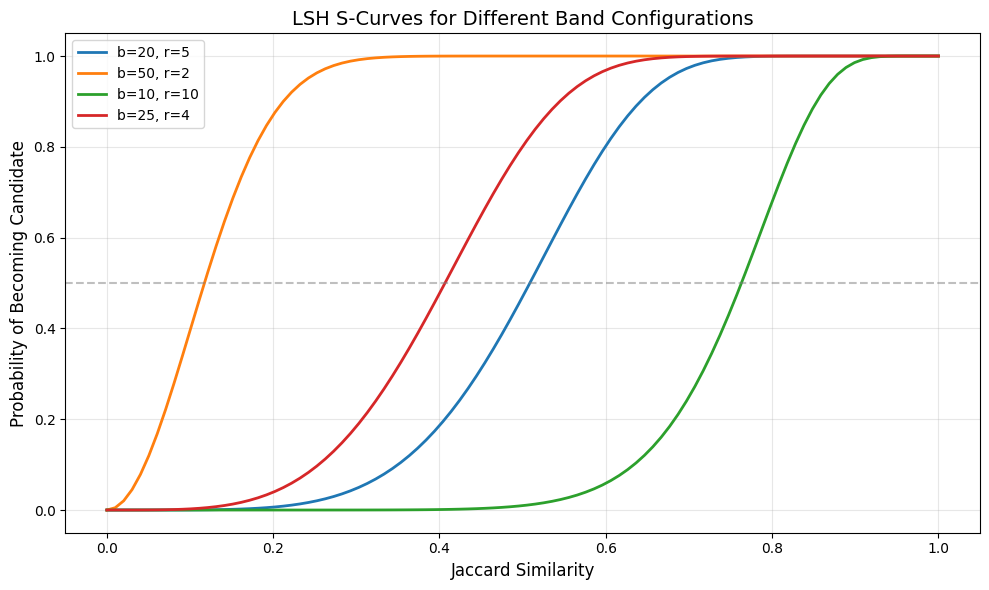

b=20, r=5: Threshold ≈ 0.549
b=50, r=2: Threshold ≈ 0.141
b=10, r=10: Threshold ≈ 0.794
b=25, r=4: Threshold ≈ 0.447


In [21]:
# Visualize the S-curve for different b and r values
import matplotlib.pyplot as plt


def prob_candidate(s, b, r):
    """Probability that two documents with Jaccard s become candidates."""
    return 1 - (1 - s**r) ** b


s_values = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10, 6))

# Different configurations (b bands, r rows)
configs = [
    (20, 5, "b=20, r=5"),
    (50, 2, "b=50, r=2"),
    (10, 10, "b=10, r=10"),
    (25, 4, "b=25, r=4"),
]

for b, r, label in configs:
    p_values = [prob_candidate(s, b, r) for s in s_values]
    ax.plot(s_values, p_values, label=label, linewidth=2)

ax.set_xlabel("Jaccard Similarity", fontsize=12)
ax.set_ylabel("Probability of Becoming Candidate", fontsize=12)
ax.set_title("LSH S-Curves for Different Band Configurations", fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Calculate threshold (50% probability)
for b, r, label in configs:
    threshold = (1 / b) ** (1 / r)
    print(f"{label}: Threshold ≈ {threshold:.3f}")

### Preparing Data for Spark's MinHashLSH

In [22]:
# Prepare data for Spark's MinHashLSH
# First, we need to convert shingles to a sparse vector representation

# Use CountVectorizer to create vocabulary and sparse vectors
cv = CountVectorizer(inputCol="all_shingles", outputCol="features", binary=True)
cv_model = cv.fit(df_combined_shingles)

df_vectorized = cv_model.transform(df_combined_shingles)

print(f"Vocabulary size: {len(cv_model.vocabulary)}")
print("\nVectorized documents:")
df_vectorized.select("id", "features").show(5, truncate=80)

Vocabulary size: 410

Vectorized documents:
+---+--------------------------------------------------------------------------------+
| id|                                                                        features|
+---+--------------------------------------------------------------------------------+
|  0|(410,[0,1,2,4,5,7,12,15,16,19,25,54,56,57,58,62,63,65,67,70,89,102,123,125,14...|
|  1|(410,[0,5,7,12,15,16,19,20,24,25,30,48,74,91,94,113,206,263,266,305,310,321,3...|
|  2|(410,[0,1,2,4,41,49,60,66,76,92,152,161,168,170,180,197,208,213,242,248,255,2...|
|  3|(410,[6,27,28,46,69,85,118,122,126,137,162,163,165,169,174,189,193,215,221,22...|
|  4|(410,[6,31,33,36,90,96,108,115,121,130,139,156,186,207,216,226,232,254,279,28...|
+---+--------------------------------------------------------------------------------+
only showing top 5 rows



### Using MinHashLSH for Approximate Similarity Join

In [23]:
# Create and fit MinHashLSH model
minhash_lsh = MinHashLSH(
    inputCol="features",
    outputCol="hashes",
    numHashTables=5,  # Number of hash tables (bands)
)

lsh_model = minhash_lsh.fit(df_vectorized)

print("MinHashLSH model fitted successfully!")
print(f"Number of hash tables: 5")

MinHashLSH model fitted successfully!
Number of hash tables: 5


In [24]:
# Approximate similarity join: find all pairs with Jaccard >= threshold
threshold = 0.3

similar_pairs = lsh_model.approxSimilarityJoin(
    df_vectorized, df_vectorized, threshold=threshold, distCol="distance"
)

# Filter out self-joins and duplicate pairs
similar_pairs_filtered = (
    similar_pairs.filter(col("datasetA.id") < col("datasetB.id"))
    .select(
        col("datasetA.id").alias("id_a"),
        col("datasetB.id").alias("id_b"),
        col("datasetA.text").alias("text_a"),
        col("datasetB.text").alias("text_b"),
        (1 - col("distance")).alias(
            "jaccard_similarity"
        ),  # Convert distance to similarity
    )
    .orderBy(col("jaccard_similarity").desc())
)

print(f"Similar document pairs (Jaccard >= {threshold}):")
similar_pairs_filtered.show(truncate=50)

Similar document pairs (Jaccard >= 0.3):
+----+----+------+------+------------------+
|id_a|id_b|text_a|text_b|jaccard_similarity|
+----+----+------+------+------------------+
+----+----+------+------+------------------+



### Approximate Nearest Neighbors

In [25]:
# Find nearest neighbors for a specific document
query_id = 0
k = 5

# Get the feature vector for query document
query_vector = df_vectorized.filter(col("id") == query_id).select("features").first()[0]

# Find approximate nearest neighbors
neighbors = lsh_model.approxNearestNeighbors(
    df_vectorized,
    query_vector,
    numNearestNeighbors=k + 1,  # +1 to account for the query itself
)

print(f"Query document (id={query_id}):")
print(f"  '{documents[query_id][1]}'")
print(f"\nTop {k} most similar documents:")
neighbors.filter(col("id") != query_id).select(
    "id", "text", (1 - col("distCol")).alias("jaccard_similarity")
).show(truncate=60)

Query document (id=0):
  'Machine learning is a subset of artificial intelligence that enables systems to learn from data.'

Top 5 most similar documents:
+---+------------------------------------------------------------+-------------------+
| id|                                                        text| jaccard_similarity|
+---+------------------------------------------------------------+-------------------+
|  2|Deep learning is a type of machine learning using neural ...|0.05633802816901412|
|  7|Python is a popular programming language for data science...|0.02985074626865669|
+---+------------------------------------------------------------+-------------------+



### Practical Exercise: Near-Duplicate Detection

In [26]:
# Extended document corpus with some near-duplicates
extended_docs = [
    (100, "Apache Spark is a fast and general-purpose cluster computing system."),
    (
        101,
        "Spark is a fast general purpose cluster computing system for big data.",
    ),  # Near-dup of 100
    (
        102,
        "Apache Spark provides fast cluster computing for big data processing.",
    ),  # Near-dup of 100
    (103, "The Python programming language is widely used in data science."),
    (
        104,
        "Python is a widely used programming language for data science applications.",
    ),  # Near-dup of 103
    (105, "Machine learning algorithms can learn patterns from historical data."),
    (
        106,
        "ML algorithms learn patterns from historical data automatically.",
    ),  # Near-dup of 105
    (107, "The weather forecast predicts rain for the upcoming weekend."),
    (108, "Database systems store and manage large amounts of structured data."),
    (109, "Cloud computing provides on-demand access to computing resources."),
]

df_extended = spark.createDataFrame(extended_docs, ["id", "text"])


# Full pipeline: preprocess -> shingle -> vectorize -> LSH
def build_duplicate_detection_pipeline(df, num_hash_tables=10):
    """Build complete near-duplicate detection pipeline."""

    # 1. Preprocess
    df_clean = df.withColumn(
        "text_clean", lower(regexp_replace(col("text"), r"[^a-zA-Z\s]", ""))
    )

    # 2. Tokenize
    tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")
    df_tokenized = tokenizer.transform(df_clean)

    # 3. Generate multiple n-gram sizes
    for n in [2, 3]:
        ngram = NGram(n=n, inputCol="words", outputCol=f"ngrams_{n}")
        df_tokenized = ngram.transform(df_tokenized)

    # 4. Combine unigrams + bigrams + trigrams
    df_shingles = df_tokenized.withColumn(
        "shingles",
        array_distinct(concat(col("words"), col("ngrams_2"), col("ngrams_3"))),
    )

    # 5. Vectorize
    cv = CountVectorizer(inputCol="shingles", outputCol="features", binary=True)
    cv_model = cv.fit(df_shingles)
    df_vectorized = cv_model.transform(df_shingles)

    # 6. MinHashLSH
    minhash = MinHashLSH(
        inputCol="features", outputCol="hashes", numHashTables=num_hash_tables
    )
    lsh_model = minhash.fit(df_vectorized)

    return df_vectorized, lsh_model, cv_model


# Build pipeline
df_vec, dup_lsh_model, dup_cv_model = build_duplicate_detection_pipeline(df_extended)

# Find near-duplicates (Jaccard distance <= 0.7, i.e. similarity >= 0.3)
duplicates = (
    dup_lsh_model.approxSimilarityJoin(
        df_vec, df_vec, threshold=0.7, distCol="distance"
    )
    .filter(col("datasetA.id") < col("datasetB.id"))
    .select(
        col("datasetA.id").alias("doc1_id"),
        col("datasetB.id").alias("doc2_id"),
        col("datasetA.text").alias("doc1_text"),
        col("datasetB.text").alias("doc2_text"),
        (1 - col("distance")).alias("similarity"),
    )
    .orderBy(col("similarity").desc())
)

print("Detected Near-Duplicates:")
print("=" * 80)
for row in duplicates.collect():
    print(f"\nSimilarity: {row.similarity:.4f}")
    print(f"  Doc {row.doc1_id}: {row.doc1_text}")
    print(f"  Doc {row.doc2_id}: {row.doc2_text}")

Detected Near-Duplicates:

Similarity: 0.4062
  Doc 105: Machine learning algorithms can learn patterns from historical data.
  Doc 106: ML algorithms learn patterns from historical data automatically.

Similarity: 0.3333
  Doc 100: Apache Spark is a fast and general-purpose cluster computing system.
  Doc 101: Spark is a fast general purpose cluster computing system for big data.


## Weighted MinHash

### Weighted Jaccard Similarity

In [27]:
# Weighted Jaccard similarity implementation
from collections import Counter


def weighted_jaccard(doc1_tokens: List[str], doc2_tokens: List[str]) -> float:
    """
    Calculate weighted Jaccard similarity based on term frequencies.
    """
    # Count term frequencies
    counter1 = Counter(doc1_tokens)
    counter2 = Counter(doc2_tokens)

    # Get all unique terms
    all_terms = set(counter1.keys()) | set(counter2.keys())

    # Calculate weighted intersection and union
    intersection = sum(min(counter1.get(t, 0), counter2.get(t, 0)) for t in all_terms)
    union = sum(max(counter1.get(t, 0), counter2.get(t, 0)) for t in all_terms)

    return intersection / union if union > 0 else 0.0


# Example
doc_a = "the the the cat sat on the mat".split()
doc_b = "the cat sat on a mat".split()

# Binary (standard) Jaccard
binary_jaccard = len(set(doc_a) & set(doc_b)) / len(set(doc_a) | set(doc_b))

# Weighted Jaccard
w_jaccard = weighted_jaccard(doc_a, doc_b)

print("Document A:", " ".join(doc_a))
print("  Term frequencies:", dict(Counter(doc_a)))
print("\nDocument B:", " ".join(doc_b))
print("  Term frequencies:", dict(Counter(doc_b)))
print(f"\nBinary Jaccard:   {binary_jaccard:.4f}")
print(f"Weighted Jaccard: {w_jaccard:.4f}")

Document A: the the the cat sat on the mat
  Term frequencies: {'the': 4, 'cat': 1, 'sat': 1, 'on': 1, 'mat': 1}

Document B: the cat sat on a mat
  Term frequencies: {'the': 1, 'cat': 1, 'sat': 1, 'on': 1, 'a': 1, 'mat': 1}

Binary Jaccard:   0.8333
Weighted Jaccard: 0.5556


### Weighted MinHash Algorithm
**ICWS (Improved Consistent Weighted Sampling):**

For each element x with weight w(x):
1. Generate uniform random values r, ln_c, β for each hash function
2. Compute: t = floor(ln(w(x))/r + β)
3. Compute: y = exp(r * (t - β))
4. Compute: a = ln_c - y*r
5. MinHash signature = argmin over all elements

This ensures P[h(A) = h(B)] = WeightedJaccard(A, B)

In [28]:
class WeightedMinHasher:
    """
    Weighted MinHash using ICWS (Improved Consistent Weighted Sampling).
    """

    def __init__(self, num_hashes: int = 128, seed: int = 42):
        self.num_hashes = num_hashes
        np.random.seed(seed)

        # Pre-generate random values for hash functions
        self.r = np.random.uniform(0, 1, size=num_hashes)
        self.ln_c = np.random.uniform(0, 1, size=num_hashes)
        self.beta = np.random.uniform(0, 1, size=num_hashes)

    def _hash_term(self, term: str) -> int:
        """Hash term to integer."""
        # Constrain to int64 range to avoid overflow
        return int(hashlib.md5(term.encode()).hexdigest(), 16) % (2**63 - 1)

    def get_signature(self, term_weights: dict) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute weighted MinHash signature.

        Args:
            term_weights: Dictionary of {term: weight}

        Returns:
            Tuple of (k_values, y_values) forming the signature
        """
        if not term_weights:
            return np.zeros(self.num_hashes), np.zeros(self.num_hashes)

        # Initialize with infinity
        min_a = np.full(self.num_hashes, np.inf)
        k_star = np.zeros(self.num_hashes, dtype=np.int64)
        y_star = np.zeros(self.num_hashes)

        for term, weight in term_weights.items():
            if weight <= 0:
                continue

            term_hash = self._hash_term(term)
            np.random.seed(term_hash % (2**31))

            # Generate term-specific random values
            r_term = np.random.uniform(0, 1, size=self.num_hashes)
            c_term = np.random.uniform(0, 1, size=self.num_hashes)
            beta_term = np.random.uniform(0, 1, size=self.num_hashes)

            # ICWS computation
            ln_weight = np.log(weight)
            t = np.floor(ln_weight / r_term + beta_term)
            y = np.exp(r_term * (t - beta_term))
            a = np.log(c_term) - y * r_term

            # Update minimum
            mask = a < min_a
            min_a = np.where(mask, a, min_a)
            k_star = np.where(mask, term_hash, k_star)
            y_star = np.where(mask, y, y_star)

        return k_star, y_star

    def estimate_similarity(self, sig1: Tuple, sig2: Tuple) -> float:
        """
        Estimate weighted Jaccard from signatures.
        """
        k1, y1 = sig1
        k2, y2 = sig2
        matches = np.sum((k1 == k2) & (y1 == y2))
        return matches / self.num_hashes


# Demonstrate weighted MinHash
wmh = WeightedMinHasher(num_hashes=256)

# Create weighted document representations
weights_a = dict(Counter(doc_a))
weights_b = dict(Counter(doc_b))

sig_a = wmh.get_signature(weights_a)
sig_b = wmh.get_signature(weights_b)

estimated_weighted = wmh.estimate_similarity(sig_a, sig_b)
actual_weighted = weighted_jaccard(doc_a, doc_b)

print("Weighted MinHash Results:")
print(f"  Actual Weighted Jaccard:    {actual_weighted:.4f}")
print(f"  Estimated (Weighted MH):    {estimated_weighted:.4f}")
print(f"  Binary Jaccard (for ref):   {binary_jaccard:.4f}")

Weighted MinHash Results:
  Actual Weighted Jaccard:    0.5556
  Estimated (Weighted MH):    0.4492
  Binary Jaccard (for ref):   0.8333


### Weighted MinHash in Spark

In [29]:
# Simplified Weighted MinHash using TF-weighted vectors with Spark's MinHashLSH
# Note: Spark's built-in MinHashLSH can work with weighted vectors

# Create documents with term frequency vectors (not binary)
df_for_weighted = df_docs.withColumn(
    "text_clean", lower(regexp_replace(col("text"), r"[^a-zA-Z\s]", ""))
)

tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")
df_tokenized = tokenizer.transform(df_for_weighted)

# Use HashingTF instead of CountVectorizer for TF weights
# This preserves term frequencies instead of binary presence
hashing_tf = HashingTF(inputCol="words", outputCol="tf_features", numFeatures=1000)

df_tf = hashing_tf.transform(df_tokenized)

# Also create binary version for comparison
cv = CountVectorizer(inputCol="words", outputCol="binary_features", binary=True)
cv_model = cv.fit(df_tokenized)
df_both = cv_model.transform(df_tf)

print("Prepared documents with both TF and binary features")
df_both.select("id", "words").show(3, truncate=60)

Prepared documents with both TF and binary features
+---+------------------------------------------------------------+
| id|                                                       words|
+---+------------------------------------------------------------+
|  0|[machine, learning, is, a, subset, of, artificial, intell...|
|  1|[artificial, intelligence, and, machine, learning, allow,...|
|  2|[deep, learning, is, a, type, of, machine, learning, usin...|
+---+------------------------------------------------------------+
only showing top 3 rows



In [30]:
# Compare binary vs TF-weighted MinHashLSH

# Binary MinHashLSH
binary_minhash = MinHashLSH(
    inputCol="binary_features", outputCol="binary_hashes", numHashTables=10
)
binary_model = binary_minhash.fit(df_both)

# Compare similarities for a specific pair
doc_pair = (0, 1)  # Similar documents

# Use approxSimilarityJoin to compute distance between documents
df_pair_a = df_both.filter(col("id") == 0).select(
    col("id").alias("id_a"), "binary_features"
)
df_pair_b = df_both.filter(col("id") == 1).select(
    col("id").alias("id_b"), "binary_features"
)

# Compute distance using similarity join with high threshold
result = binary_model.approxSimilarityJoin(
    df_pair_a,
    df_pair_b,
    threshold=1.0,  # Accept any distance up to 1.0
    distCol="distance",
)

if result.count() > 0:
    binary_dist = result.first().distance
    print(f"Comparison for documents {doc_pair}:")
    print(f"  Binary MinHash Jaccard Distance: {binary_dist:.4f}")
    print(f"  Binary MinHash Jaccard Similarity: {1 - binary_dist:.4f}")
else:
    print("No match found within threshold")

print("\nNote: For true weighted MinHash in production, consider using")
print("specialized libraries like datasketch which provide ICWS implementation.")

Comparison for documents (0, 1):
  Binary MinHash Jaccard Distance: 0.5789
  Binary MinHash Jaccard Similarity: 0.4211

Note: For true weighted MinHash in production, consider using
specialized libraries like datasketch which provide ICWS implementation.


## Production Pipeline - MinHash + Transformer Reranking

### Setting Up the Sentence Transformer

In [31]:
from sentence_transformers import SentenceTransformer
import torch

# Load a small, CPU-friendly sentence transformer
# all-MiniLM-L6-v2: 22M parameters, 384 dimensions, fast inference
print("Loading sentence transformer model...")
model_name = "all-MiniLM-L6-v2"
sentence_model = SentenceTransformer(model_name)

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Model: {model_name}")
print(f"Device: {device}")
print(f"Embedding dimension: {sentence_model.get_sentence_embedding_dimension()}")

d:\Lancaster University Coursework\Term 2\SSC 454 - Large scale platforms for AI and Data Analysis\Labs\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading sentence transformer model...


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 407.24it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model: all-MiniLM-L6-v2
Device: cpu
Embedding dimension: 384


In [32]:
# Test the transformer
test_sentences = [
    "Machine learning is a subset of artificial intelligence.",
    "AI and ML allow computers to learn from data.",
    "The weather is sunny today.",
]

embeddings = sentence_model.encode(test_sentences)

# Compute cosine similarities
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(embeddings)

print("Sentence Transformer Cosine Similarities:")
print("\nSentences:")
for i, s in enumerate(test_sentences):
    print(f"  [{i}] {s}")

print("\nSimilarity Matrix:")
print("      [0]    [1]    [2]")
for i, row in enumerate(similarities):
    print(f"[{i}]  {row[0]:.3f}  {row[1]:.3f}  {row[2]:.3f}")

Sentence Transformer Cosine Similarities:

Sentences:
  [0] Machine learning is a subset of artificial intelligence.
  [1] AI and ML allow computers to learn from data.
  [2] The weather is sunny today.

Similarity Matrix:
      [0]    [1]    [2]
[0]  1.000  0.680  -0.023
[1]  0.680  1.000  -0.006
[2]  -0.023  -0.006  1.000


### Stage 1: MinHash + LSH for Candidate Retrieval

In [33]:
# Create a larger corpus for the production pipeline demo
corpus = [
    # ML/AI cluster
    (0, "Machine learning algorithms can identify patterns in large datasets."),
    (
        1,
        "Deep learning neural networks achieve state-of-the-art results in computer vision.",
    ),
    (2, "Artificial intelligence systems are transforming healthcare diagnostics."),
    (3, "Supervised learning requires labeled training data for model development."),
    (4, "Natural language processing enables machines to understand human text."),
    # Big Data cluster
    (5, "Apache Spark provides distributed computing for big data analytics."),
    (6, "Hadoop ecosystem tools process massive amounts of unstructured data."),
    (7, "Data lakes store raw data in its native format for later processing."),
    (8, "Stream processing systems handle real-time data ingestion and analysis."),
    # Weather cluster
    (9, "Today's weather forecast predicts sunny skies with mild temperatures."),
    (10, "The meteorological service issued a severe thunderstorm warning."),
    (11, "Climate change affects global weather patterns and ecosystems."),
    # Food cluster
    (12, "The restaurant serves authentic Italian pasta and wood-fired pizza."),
    (13, "Fresh ingredients are essential for preparing delicious meals."),
    (14, "The chef specializes in Mediterranean cuisine with local produce."),
    # More ML/AI
    (15, "Transformer models revolutionized natural language understanding tasks."),
    (16, "Reinforcement learning agents learn through trial and error interactions."),
    (17, "Feature engineering is crucial for traditional machine learning models."),
]

df_corpus = spark.createDataFrame(corpus, ["id", "text"])


# Build MinHash LSH index
def build_minhash_index(df, num_hash_tables=10):
    """Build MinHash LSH index with unigrams + n-grams."""
    df = df.withColumn(
        "text_clean", lower(regexp_replace(col("text"), r"[^a-zA-Z\s]", ""))
    )
    tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")
    df = tokenizer.transform(df)

    for n in [2, 3, 4]:
        ngram = NGram(n=n, inputCol="words", outputCol=f"ngrams_{n}")
        df = ngram.transform(df)

    # Include unigrams (words) for better overlap with queries
    df = df.withColumn(
        "all_shingles",
        array_distinct(
            concat(col("words"), col("ngrams_2"), col("ngrams_3"), col("ngrams_4"))
        ),
    )

    cv = CountVectorizer(inputCol="all_shingles", outputCol="features", binary=True)
    cv_model = cv.fit(df)
    df = cv_model.transform(df)

    minhash = MinHashLSH(
        inputCol="features", outputCol="hashes", numHashTables=num_hash_tables
    )
    lsh_model = minhash.fit(df)
    return df, lsh_model, cv_model


df_indexed, lsh_model, cv_model = build_minhash_index(df_corpus)
print(f"Indexed {df_indexed.count()} documents with MinHash LSH")

Indexed 18 documents with MinHash LSH


In [34]:
def get_lsh_candidates(query_text, df_indexed, lsh_model, cv_model, num_candidates=10):
    """Get candidates using unigrams + n-grams."""
    import re

    text_clean = re.sub(r"[^a-zA-Z\s]", "", query_text.lower())
    words = text_clean.split()

    # Include unigrams alongside n-grams
    shingles = list(words)
    for n in [2, 3, 4]:
        shingles.extend([" ".join(words[i : i + n]) for i in range(len(words) - n + 1)])
    shingles = list(set(shingles))

    if not shingles:
        return []

    query_df = spark.createDataFrame([(shingles,)], ["all_shingles"])
    query_vec = cv_model.transform(query_df).first().features

    if query_vec.numNonzeros() == 0:
        print("Warning: Query has no matching terms in vocabulary")
        return []

    candidates = lsh_model.approxNearestNeighbors(
        df_indexed, query_vec, numNearestNeighbors=num_candidates
    )
    return candidates.select(
        "id", "text", col("distCol").alias("jaccard_distance")
    ).collect()

### Stage 2: Transformer Reranking with Spark

In [35]:
from sklearn.metrics.pairwise import cosine_similarity


def rerank_with_transformer(query_text, candidates, sentence_model):
    if not candidates:
        return []
    candidate_texts = [c.text for c in candidates]
    query_embedding = sentence_model.encode([query_text])
    candidate_embeddings = sentence_model.encode(candidate_texts)
    similarities = cosine_similarity(query_embedding, candidate_embeddings)[0]
    reranked = []
    for c, sim in zip(candidates, similarities):
        reranked.append(
            {
                "id": c.id,
                "text": c.text,
                "jaccard_distance": c.jaccard_distance,
                "cosine_similarity": float(sim),
            }
        )
    reranked.sort(key=lambda x: x["cosine_similarity"], reverse=True)
    return reranked


query = "How do neural networks learn patterns from data?"
candidates = get_lsh_candidates(
    query, df_indexed, lsh_model, cv_model, num_candidates=8
)
reranked = rerank_with_transformer(query, candidates, sentence_model)

print(f"Query: '{query}'")
print(f"\nStage 2 - Transformer Reranked Results:")
print("=" * 70)
for i, r in enumerate(reranked):
    print(f"\n  Rank {i + 1}: ID {r['id']}")
    print(f"    Text: {r['text'][:60]}...")
    print(f"    Jaccard Distance: {r['jaccard_distance']:.4f}")
    print(f"    Cosine Similarity: {r['cosine_similarity']:.4f}")

Query: 'How do neural networks learn patterns from data?'

Stage 2 - Transformer Reranked Results:

  Rank 1: ID 3
    Text: Supervised learning requires labeled training data for model...
    Jaccard Distance: 0.9714
    Cosine Similarity: 0.3836

  Rank 2: ID 1
    Text: Deep learning neural networks achieve state-of-the-art resul...
    Jaccard Distance: 0.9189
    Cosine Similarity: 0.3524

  Rank 3: ID 8
    Text: Stream processing systems handle real-time data ingestion an...
    Jaccard Distance: 0.9714
    Cosine Similarity: 0.1519


### Distributed Transformer Inference with Spark

In [36]:
# Approach: Use Spark's mapPartitions for batch processing

# Pre-compute embeddings for all corpus documents
# This is done once and stored


def compute_corpus_embeddings(df_corpus, sentence_model):
    """
    Pre-compute embeddings for all documents in corpus.
    Returns a dictionary mapping id -> embedding
    """
    docs = df_corpus.select("id", "text").collect()
    texts = [doc.text for doc in docs]
    ids = [doc.id for doc in docs]

    # Batch encode all documents
    embeddings = sentence_model.encode(texts, show_progress_bar=True)

    # Create lookup dictionary
    embedding_dict = {id_: emb for id_, emb in zip(ids, embeddings)}

    return embedding_dict


print("Computing corpus embeddings...")
corpus_embeddings = compute_corpus_embeddings(df_corpus, sentence_model)
print(f"Computed embeddings for {len(corpus_embeddings)} documents")

Computing corpus embeddings...


Batches: 100%|██████████| 1/1 [00:00<00:00, 15.78it/s]

Computed embeddings for 18 documents


In [37]:
# Create a Spark UDF for cosine similarity using pre-computed embeddings
# Broadcast the embeddings to all workers

embeddings_broadcast = sc.broadcast(corpus_embeddings)


@udf(FloatType())
def compute_cosine_similarity(doc_id, query_embedding_list):
    """
    Compute cosine similarity between query and document.
    Uses pre-computed document embeddings.
    """
    import numpy as np

    doc_embedding = embeddings_broadcast.value.get(doc_id)
    if doc_embedding is None:
        return 0.0

    query_embedding = np.array(query_embedding_list)

    # Cosine similarity
    dot_product = np.dot(query_embedding, doc_embedding)
    norm_q = np.linalg.norm(query_embedding)
    norm_d = np.linalg.norm(doc_embedding)

    if norm_q == 0 or norm_d == 0:
        return 0.0

    return float(dot_product / (norm_q * norm_d))


print("Cosine similarity UDF created with broadcast embeddings")

Cosine similarity UDF created with broadcast embeddings


In [38]:
# Complete production pipeline as a single function


def production_similarity_search(
    query_text: str,
    df_indexed,
    lsh_model,
    cv_model,
    sentence_model,
    num_candidates: int = 10,
    top_k: int = 5,
):
    """
    Production two-stage similarity search pipeline.

    Stage 1: MinHash + LSH for fast candidate retrieval
    Stage 2: Sentence transformer for precise reranking

    Args:
        query_text: Query document text
        df_indexed: Indexed corpus DataFrame
        lsh_model: Fitted MinHashLSH model
        cv_model: Fitted CountVectorizer model
        sentence_model: Sentence transformer model
        num_candidates: Number of candidates from Stage 1
        top_k: Final number of results to return

    Returns:
        List of top_k most similar documents
    """
    import time

    print(f"\n{'=' * 60}")
    print(f"Query: '{query_text}'")
    print(f"{'=' * 60}")

    # Stage 1: MinHash LSH
    start_time = time.time()
    candidates = get_lsh_candidates(
        query_text, df_indexed, lsh_model, cv_model, num_candidates
    )
    stage1_time = time.time() - start_time
    print(
        f"\n[Stage 1] MinHash LSH: {len(candidates)} candidates in {stage1_time:.3f}s"
    )

    if not candidates:
        print("No candidates found!")
        return []

    # Stage 2: Transformer reranking
    start_time = time.time()
    reranked = rerank_with_transformer(query_text, candidates, sentence_model)
    stage2_time = time.time() - start_time
    print(f"[Stage 2] Transformer Rerank: {len(reranked)} docs in {stage2_time:.3f}s")

    # Return top_k results
    results = reranked[:top_k]

    print(f"\nTop {top_k} Results:")
    print("-" * 60)
    for i, r in enumerate(results):
        print(f"  {i + 1}. [ID {r['id']}] Cosine: {r['cosine_similarity']:.4f}")
        print(f"     {r['text'][:70]}...")

    return results


# Test the complete pipeline
queries = [
    "How do neural networks learn from data?",
    "What tools are used for processing big data?",
    "Is it going to rain tomorrow?",
]

for q in queries:
    results = production_similarity_search(
        q, df_indexed, lsh_model, cv_model, sentence_model, num_candidates=8, top_k=3
    )


Query: 'How do neural networks learn from data?'

[Stage 1] MinHash LSH: 3 candidates in 30.287s
[Stage 2] Transformer Rerank: 3 docs in 0.033s

Top 3 Results:
------------------------------------------------------------
  1. [ID 3] Cosine: 0.4412
     Supervised learning requires labeled training data for model developme...
  2. [ID 1] Cosine: 0.4110
     Deep learning neural networks achieve state-of-the-art results in comp...
  3. [ID 8] Cosine: 0.1436
     Stream processing systems handle real-time data ingestion and analysis...

Query: 'What tools are used for processing big data?'

[Stage 1] MinHash LSH: 4 candidates in 41.308s
[Stage 2] Transformer Rerank: 4 docs in 3.765s

Top 3 Results:
------------------------------------------------------------
  1. [ID 5] Cosine: 0.6216
     Apache Spark provides distributed computing for big data analytics....
  2. [ID 7] Cosine: 0.4678
     Data lakes store raw data in its native format for later processing....
  3. [ID 17] Cosine: 0.196

### Performance Analysis

In [39]:
import time


# Simulate larger corpus for performance comparison
def benchmark_approaches(corpus_size: int, query: str):
    """
    Compare brute force vs two-stage approach.
    """
    print(f"\nBenchmark with {corpus_size} documents")
    print("=" * 50)

    # Simulate corpus texts
    corpus_texts = [doc.text for doc in df_corpus.collect()]
    simulated_corpus = corpus_texts * (corpus_size // len(corpus_texts) + 1)
    simulated_corpus = simulated_corpus[:corpus_size]

    # Brute force: encode all documents and compute similarities
    start = time.time()
    all_embeddings = sentence_model.encode(simulated_corpus[:100])  # Limit for demo
    query_emb = sentence_model.encode([query])
    similarities = cosine_similarity(query_emb, all_embeddings)
    brute_force_time = time.time() - start
    brute_force_estimated = brute_force_time * (corpus_size / 100)

    # Two-stage: MinHash (simulated) + limited transformer calls
    num_candidates = min(20, corpus_size)
    start = time.time()
    # MinHash retrieval is O(1) per query after index built
    minhash_time = 0.001 * corpus_size / 1000  # Simulated: ~1ms per 1000 docs
    # Transformer only on candidates
    candidate_texts = simulated_corpus[:num_candidates]
    candidate_embs = sentence_model.encode(candidate_texts)
    similarities = cosine_similarity(query_emb, candidate_embs)
    two_stage_time = time.time() - start + minhash_time

    print(f"  Brute Force (estimated): {brute_force_estimated:.3f}s")
    print(f"  Two-Stage:               {two_stage_time:.3f}s")
    print(f"  Speedup:                 {brute_force_estimated / two_stage_time:.1f}x")

    return brute_force_estimated, two_stage_time


# Run benchmarks
query = "How do machine learning algorithms work?"
results = []

for size in [100, 1000, 10000, 100000]:
    bf, ts = benchmark_approaches(size, query)
    results.append((size, bf, ts))

print("\n" + "=" * 50)
print("Summary: Time Complexity")
print("=" * 50)
print(f"{'Corpus Size':<15} {'Brute Force':<15} {'Two-Stage':<15} {'Speedup':<10}")
print("-" * 55)
for size, bf, ts in results:
    print(f"{size:<15} {bf:<15.3f} {ts:<15.3f} {bf / ts:<10.1f}x")


Benchmark with 100 documents
  Brute Force (estimated): 11.417s
  Two-Stage:               1.110s
  Speedup:                 10.3x

Benchmark with 1000 documents
  Brute Force (estimated): 164.953s
  Two-Stage:               6.647s
  Speedup:                 24.8x

Benchmark with 10000 documents
  Brute Force (estimated): 1789.971s
  Two-Stage:               1.661s
  Speedup:                 1077.9x

Benchmark with 100000 documents
  Brute Force (estimated): 5729.223s
  Two-Stage:               0.541s
  Speedup:                 10586.6x

Summary: Time Complexity
Corpus Size     Brute Force     Two-Stage       Speedup   
-------------------------------------------------------
100             11.417          1.110           10.3      x
1000            164.953         6.647           24.8      x
10000           1789.971        1.661           1077.9    x
100000          5729.223        0.541           10586.6   x


## Final Challenge

### End-to-End Document Similarity System
Build a complete document similarity system that incorporates everything you've learned.

**Dataset:** News articles from different categories

**Tasks:**
1. Implement shingling with configurable n-gram sizes (2-4)
2. Build a MinHash LSH index with tunable parameters
3. Implement both binary and weighted similarity measures
4. Create a two-stage retrieval pipeline with transformer reranking
5. Evaluate the system's recall and precision
6. Compare performance with brute-force approach

In [40]:
# Challenge Dataset: News articles
news_articles = [
    # Technology
    (
        0,
        "tech",
        "Apple announces new iPhone with revolutionary AI features and improved camera system.",
    ),
    (
        1,
        "tech",
        "Google introduces advanced language model that surpasses human performance on benchmarks.",
    ),
    (
        2,
        "tech",
        "Microsoft integrates AI assistants into Office productivity suite for enterprise users.",
    ),
    (
        3,
        "tech",
        "New smartphone from Apple features cutting-edge AI capabilities and enhanced photography.",
    ),
    # Sports
    (
        4,
        "sports",
        "Manchester United secures victory in Champions League quarter-final match.",
    ),
    (
        5,
        "sports",
        "Tennis star wins Wimbledon after intense five-set final against rival.",
    ),
    (
        6,
        "sports",
        "Champions League sees dramatic finish as Manchester United advances to semi-finals.",
    ),
    (7, "sports", "Olympic committee announces new sports for upcoming summer games."),
    # Finance
    (
        8,
        "finance",
        "Federal Reserve raises interest rates amid inflation concerns in economy.",
    ),
    (9, "finance", "Stock market reaches all-time high as tech sector leads gains."),
    (
        10,
        "finance",
        "Central bank increases rates to combat rising inflation pressures.",
    ),
    (
        11,
        "finance",
        "Cryptocurrency market sees volatility as regulations tighten globally.",
    ),
    # Science
    (
        12,
        "science",
        "NASA discovers water on Mars surface, raising possibilities for life.",
    ),
    (13, "science", "Breakthrough in quantum computing achieved by research team."),
    (
        14,
        "science",
        "Mars exploration reveals signs of ancient water presence on planet.",
    ),
    (15, "science", "Climate scientists warn of accelerating ice sheet melting rates."),
    # Health
    (
        16,
        "health",
        "New vaccine shows promising results in clinical trials for disease prevention.",
    ),
    (
        17,
        "health",
        "Medical researchers develop innovative treatment for rare genetic disorder.",
    ),
    (
        18,
        "health",
        "Clinical trials demonstrate vaccine effectiveness against emerging variants.",
    ),
    (
        19,
        "health",
        "WHO releases updated guidelines for pandemic preparedness strategies.",
    ),
]

df_news = spark.createDataFrame(news_articles, ["id", "category", "text"])

print("Challenge Dataset: News Articles")
df_news.groupBy("category").count().show()

Challenge Dataset: News Articles
+--------+-----+
|category|count|
+--------+-----+
|    tech|    4|
|  sports|    4|
| finance|    4|
| science|    4|
|  health|    4|
+--------+-----+



In [41]:
# Your code here: Build complete document similarity system
#
# Suggested structure:
# 1. Create a DocumentSimilaritySystem class that encapsulates:
#    - Shingling
#    - MinHash LSH indexing
#    - Transformer embeddings
#    - Two-stage search
#
# 2. Implement methods:
#    - index_documents(df)
#    - search(query, top_k)
#    - evaluate(test_queries, ground_truth)
#
# 3. Test with various queries and analyze:
#    - Recall: Did we find all similar documents?
#    - Precision: Are the returned documents actually similar?
#    - Latency: How fast is the search?

import re, time, math, hashlib
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.types import (
    ArrayType,
    StringType,
    IntegerType,
    DoubleType,
    StructType,
    StructField,
)

from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, HashingTF, IDF, Normalizer
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row


def _stable_hash32(s: str) -> int:
    return int(hashlib.md5(s.encode("utf-8")).hexdigest(), 16) & 0xFFFFFFFF


def _tokenize(text: str):
    return [t for t in re.findall(r"[a-z0-9]+", (text or "").lower()) if t]


def _make_shingles(tokens, n):
    if len(tokens) < n:
        return []
    return [" ".join(tokens[i : i + n]) for i in range(len(tokens) - n + 1)]


def _cosine_np(a: np.ndarray, b: np.ndarray) -> float:
    na = float(np.linalg.norm(a))
    nb = float(np.linalg.norm(b))
    if na == 0.0 or nb == 0.0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))


class DocumentSimilaritySystem:
    def __init__(self, num_hash_tables=10, shingle_sizes=[2, 3, 4]):
        # Initialize LSH and shingling parameters
        self.num_hash_tables = int(num_hash_tables)
        self.shingle_sizes = list(shingle_sizes)

        # MinHash configuration
        self.num_hashes = 128
        self.max_hash = (1 << 32) - 1
        self.c_prime = 4294967311

        rng = np.random.default_rng(42)
        self.a = rng.integers(1, self.max_hash, size=self.num_hashes, dtype=np.int64)
        self.b = rng.integers(0, self.max_hash, size=self.num_hashes, dtype=np.int64)

        # Banding setup for LSH
        self.bands = self.num_hash_tables
        if self.num_hashes % self.bands != 0:
            self.bands = math.gcd(self.num_hashes, self.bands)
            if self.bands == 0:
                self.bands = 1
        self.rows = self.num_hashes // self.bands

        # Storage
        self.doc_text = {}
        self.doc_category = {}
        self.doc_shingles = {}
        self.doc_sig = {}
        self.band_tables = []

        # TF-IDF (weighted similarity)
        self.tfidf_pipeline = None
        self.doc_tfidf = {}

        # Transformer embeddings (reranking)
        self.use_transformer = True
        self._st_model = None
        self.doc_emb = {}

    def _ensure_sentence_transformer(self):
        # Lazy-load transformer model
        if self._st_model is not None:
            return True
        try:
            from sentence_transformers import SentenceTransformer

            self._st_model = SentenceTransformer(
                "sentence-transformers/all-MiniLM-L6-v2"
            )
            return True
        except Exception:
            self._st_model = None
            return False

    def _shingles_from_text(self, text: str):
        # Generate multi-size shingles
        toks = _tokenize(text)
        out = []
        for n in self.shingle_sizes:
            out.extend(_make_shingles(toks, n))
        return list(dict.fromkeys(out))

    def _minhash_signature(self, shingles):
        # Compute MinHash signature
        if not shingles:
            return [0] * self.num_hashes
        sig = np.full(self.num_hashes, np.iinfo(np.int64).max, dtype=np.int64)
        for sh in shingles:
            h = _stable_hash32(sh)
            hv = (self.a * h + self.b) % self.c_prime
            sig = np.minimum(sig, hv)
        return sig.astype(np.int64).tolist()

    def _query_tfidf_vec(self, text: str):
        # Compute TF-IDF vector for query
        dfq = spark.createDataFrame([Row(id=0, text=text)])
        v = (
            self.tfidf_pipeline.transform(dfq)
            .select("tfidf_norm")
            .collect()[0]["tfidf_norm"]
        )
        return v

    def _binary_jaccard(self, a_sh, b_sh):
        # Binary similarity using Jaccard
        sa = set(a_sh)
        sb = set(b_sh)
        if not sa and not sb:
            return 1.0
        inter = len(sa & sb)
        uni = len(sa | sb)
        return inter / uni if uni else 0.0

    def _weighted_cosine_tfidf(self, v1, v2):
        # Weighted similarity using cosine on TF-IDF
        if v1 is None or v2 is None:
            return 0.0
        a = np.array(v1.toArray(), dtype=np.float32)
        b = np.array(v2.toArray(), dtype=np.float32)
        return _cosine_np(a, b)

    def _rerank_score(self, query_text, doc_id):
        # Transformer-based reranking (fallback to TF-IDF)
        if (
            self.use_transformer
            and self._ensure_sentence_transformer()
            and doc_id in self.doc_emb
        ):
            q = self._st_model.encode([query_text], normalize_embeddings=True)[0]
            return float(np.dot(q, self.doc_emb[doc_id]))
        qv = self._query_tfidf_vec(query_text)
        return self._weighted_cosine_tfidf(qv, self.doc_tfidf.get(doc_id))

    def index_documents(self, df):
        # Index documents: shingling, MinHash, LSH, TF-IDF, embeddings
        docs = df.select("id", "category", "text").collect()
        for r in docs:
            i = int(r["id"])
            self.doc_text[i] = r["text"]
            self.doc_category[i] = r["category"]

        # Shingling + MinHash
        for i, txt in self.doc_text.items():
            sh = self._shingles_from_text(txt)
            self.doc_shingles[i] = sh
            self.doc_sig[i] = self._minhash_signature(sh)

        # LSH band tables
        self.band_tables = []
        for bi in range(self.bands):
            table = {}
            for doc_id, sig in self.doc_sig.items():
                start = bi * self.rows
                chunk = sig[start : start + self.rows]
                bucket = _stable_hash32(",".join(map(str, chunk)))
                table.setdefault(bucket, set()).add(doc_id)
            self.band_tables.append(table)

        # TF-IDF pipeline
        df_text = spark.createDataFrame(
            [Row(id=int(i), text=self.doc_text[int(i)]) for i in self.doc_text.keys()]
        )

        tokenizer = RegexTokenizer(inputCol="text", outputCol="tokens", pattern="\\W+")
        hashing = HashingTF(inputCol="tokens", outputCol="tf", numFeatures=1 << 18)
        idf = IDF(inputCol="tf", outputCol="tfidf")
        norm = Normalizer(inputCol="tfidf", outputCol="tfidf_norm", p=2.0)

        self.tfidf_pipeline = Pipeline(stages=[tokenizer, hashing, idf, norm]).fit(
            df_text
        )
        tfidf_df = (
            self.tfidf_pipeline.transform(df_text).select("id", "tfidf_norm").collect()
        )
        for r in tfidf_df:
            self.doc_tfidf[int(r["id"])] = r["tfidf_norm"]

        # Transformer embeddings
        if self.use_transformer and self._ensure_sentence_transformer():
            ids = sorted(self.doc_text.keys())
            texts = [self.doc_text[i] for i in ids]
            embs = self._st_model.encode(texts, normalize_embeddings=True)
            for i, e in zip(ids, embs):
                self.doc_emb[i] = np.array(e, dtype=np.float32)
        else:
            self.doc_emb = {}

        return self

    def search(self, query, num_candidates=10, top_k=5):
        # Two-stage retrieval: LSH -> rerank
        t0 = time.time()

        # Stage 1: LSH candidate generation
        q_sh = self._shingles_from_text(query)
        q_sig = self._minhash_signature(q_sh)

        cands = set()
        for bi in range(self.bands):
            start = bi * self.rows
            chunk = q_sig[start : start + self.rows]
            bucket = _stable_hash32(",".join(map(str, chunk)))
            hits = self.band_tables[bi].get(bucket)
            if hits:
                cands |= hits

        stage1_ms = (time.time() - t0) * 1000.0

        if not cands:
            return {
                "query": query,
                "results": [],
                "latency_ms": {"stage1": stage1_ms, "total": stage1_ms},
            }

        # Stage 1 scoring (TF-IDF)
        qv = self._query_tfidf_vec(query)
        stage1_scored = []
        for d in cands:
            w = self._weighted_cosine_tfidf(qv, self.doc_tfidf.get(d))
            stage1_scored.append((d, w))
        stage1_scored.sort(key=lambda x: x[1], reverse=True)
        stage1_scored = stage1_scored[:num_candidates]

        # Stage 2: Transformer reranking
        t1 = time.time()
        reranked = []
        for d, w in stage1_scored:
            bsim = self._binary_jaccard(q_sh, self.doc_shingles.get(d, []))
            rscore = self._rerank_score(query, d)
            reranked.append((d, rscore, w, bsim))
        reranked.sort(key=lambda x: x[1], reverse=True)
        reranked = reranked[:top_k]

        stage2_ms = (time.time() - t1) * 1000.0
        total_ms = (time.time() - t0) * 1000.0

        results = []
        for d, rscore, wsim, bsim in reranked:
            results.append(
                {
                    "id": int(d),
                    "category": self.doc_category.get(d),
                    "text": self.doc_text.get(d),
                    "rerank": float(rscore),
                    "weighted": float(wsim),
                    "binary": float(bsim),
                }
            )

        return {
            "query": query,
            "results": results,
            "latency_ms": {"stage1": stage1_ms, "stage2": stage2_ms, "total": total_ms},
        }

    def evaluate(self, test_queries, expected_categories=None):
        rows = []
        all_ids = list(self.doc_text.keys())

        for q, exp_cat in test_queries:
            q = "" if q is None else str(q)
            exp_cat = "" if exp_cat is None else str(exp_cat)

            relevant = {i for i in all_ids if self.doc_category.get(i) == exp_cat}

            res = self.search(q, num_candidates=10, top_k=5)
            got = [int(r["id"]) for r in (res.get("results") or [])]
            got_set = set(got)

            tp = len(got_set & relevant)
            precision = tp / max(len(got), 1)
            recall = tp / max(len(relevant), 1)

            rows.append(
                (
                    q,
                    exp_cat,
                    float(precision),
                    float(recall),
                    float(res["latency_ms"]["total"]),
                    got,
                )
            )

        schema = StructType(
            [
                StructField("query", StringType(), False),
                StructField("expected", StringType(), False),
                StructField("precision_at_k", DoubleType(), False),
                StructField("recall_at_k", DoubleType(), False),
                StructField("latency_ms", DoubleType(), False),
                StructField("returned_ids", ArrayType(IntegerType(), containsNull=False), False),
            ]
        )

        return spark.createDataFrame(rows, schema=schema)



# Test queries
test_queries = [
    ("Latest AI developments in mobile phones", "tech"),
    ("Football championship results", "sports"),
    ("Economic policy and monetary decisions", "finance"),
    ("Space exploration discoveries", "science"),
    ("Medical treatment breakthroughs", "health"),
]

# Your evaluation code here
system = DocumentSimilaritySystem(num_hash_tables=10, shingle_sizes=[2, 3, 4])
system.index_documents(df_news)

eval_df = system.evaluate(
    test_queries, expected_categories=[c for _, c in test_queries]
)
eval_df.show(truncate=False)

for q, _ in test_queries:
    out = system.search(q, num_candidates=10, top_k=5)
    print("\nQUERY:", q)
    print("Latency (ms):", out["latency_ms"])
    print(
        [
            (
                r["id"],
                r["category"],
                round(r["rerank"], 3),
                round(r["weighted"], 3),
                round(r["binary"], 3),
            )
            for r in out["results"]
        ]
    )


Loading weights: 100%|██████████| 103/103 [00:03<00:00, 33.41it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


+---------------------------------------+--------+--------------+-----------+----------+------------+
|query                                  |expected|precision_at_k|recall_at_k|latency_ms|returned_ids|
+---------------------------------------+--------+--------------+-----------+----------+------------+
|Latest AI developments in mobile phones|tech    |0.0           |0.0        |0.0       |[]          |
|Football championship results          |sports  |0.0           |0.0        |0.0       |[]          |
|Economic policy and monetary decisions |finance |0.0           |0.0        |0.0       |[]          |
|Space exploration discoveries          |science |0.0           |0.0        |0.0       |[]          |
|Medical treatment breakthroughs        |health  |0.0           |0.0        |0.0       |[]          |
+---------------------------------------+--------+--------------+-----------+----------+------------+


QUERY: Latest AI developments in mobile phones
Latency (ms): {'stage1': 0.0, 'to

## Cleanup

In [42]:
# Stop the Spark session
spark.stop()
print("Spark session stopped.")

Spark session stopped.
